### Import packages, connect to openEO, and define aoi

In [1]:
# import libraries
import openeo
import folium
import json
import shapely.geometry
from openeo.processes import run_udf, process, multiply, divide, pi, add, cos, sin, subtract, arccos
import xarray as xr
import math
import os
import matplotlib.pyplot as plt

In [2]:
# connect to openeo
conn = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

# out dir
outdir = "./auxiliary_data/senales"

# aoi
aoi = json.load(open('auxiliary_data/senales/senales_wgs84.geojson'))

# define time period
time_period = ['2023-02-01', '2023-02-28']

# check the aoi
region = aoi['features'][0]['geometry']
geom = shapely.geometry.shape(region)
centroid = geom.centroid
center_latlon = [centroid.y, centroid.x]

m = folium.Map(location=center_latlon, zoom_start=11)

folium.GeoJson(aoi).add_to(m)
m

Authenticated using refresh token.


### Create slope

In [3]:
# load dem
dem = conn.load_collection(
    "COPERNICUS_30",
    spatial_extent=region,
    bands=['DEM']
).reduce_dimension(dimension='t', reducer='mean')

In [4]:
slope_udf = openeo.UDF.from_file("slope_udf.py")

slope = dem.apply(process=slope_udf)

In [5]:
# rename DEM
slope = slope.rename_labels(dimension = "bands", target = ["slope"], source = ["DEM"])

In [6]:
# check 
print(slope.metadata)

CollectionMetadata({'spatial': {'bbox': [[-180, -90, 180, 90]]}, 'temporal': {'interval': [['2010-12-12T00:00:00Z', None]]}} - ['slope'] - ['bands', 'x', 'y'])


In [7]:
# # download to check output
# slope.download(os.path.join(outdir,'slope.nc'))

### Create aspect

In [8]:
aspect_udf = openeo.UDF.from_file("aspect_udf.py")

aspect = dem.apply(process=aspect_udf)

In [9]:
# rename DEM
aspect = aspect.rename_labels(dimension = "bands", target = ["aspect"], source = ["DEM"])

In [10]:
# check 
print(aspect.metadata)

CollectionMetadata({'spatial': {'bbox': [[-180, -90, 180, 90]]}, 'temporal': {'interval': [['2010-12-12T00:00:00Z', None]]}} - ['aspect'] - ['bands', 'x', 'y'])


In [11]:
# # download to check output
# aspect.download(os.path.join(outdir,'aspect.nc'))

### Zenith and Azimuth

In [12]:
s2 = conn.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=region,
    temporal_extent=time_period,
    bands=["sunZenithAngles", "sunAzimuthAngles"]  
)

In [13]:
s2 = s2.resample_spatial(resolution=10)

In [14]:
zenith = s2.filter_bands("sunZenithAngles")
azimuth = s2.filter_bands("sunAzimuthAngles")

In [15]:
# azimuth.download(os.path.join(outdir,'azimuth.nc'))

In [16]:
print(azimuth.metadata)

CollectionMetadata({'spatial': {'bbox': [[-180, -56, 180, 83]]}, 'temporal': {'interval': [['2015-07-04T00:00:00Z', None]]}} - ['sunAzimuthAngles'] - ['bands', 't', 'x', 'y'])


### Combine the datacubes into one

In [17]:
combined = slope.merge_cubes(zenith).merge_cubes(azimuth).merge_cubes(aspect)

In [18]:
combined

In [19]:
print(combined.metadata)

CollectionMetadata({'spatial': {'bbox': [[-180, -90, 180, 90]]}, 'temporal': {'interval': [['2010-12-12T00:00:00Z', None]]}} - ['slope', 'sunZenithAngles', 'sunAzimuthAngles', 'aspect'] - ['bands', 'x', 'y'])


In [20]:
# # check if merge worked
# combined.download(os.path.join(outdir,'combined.nc'))

### Solar incidence angle

In [21]:
# degree - radians conversions
deg2rad = math.pi / 180.0
rad2deg = 180.0 / math.pi

# define the solar incidence angle function per-pixel
def compute_sia(data):
    zenith_rad = multiply(data["zenith"], deg2rad)
    azimuth_rad = multiply(data["azimuth"], deg2rad)
    slope_rad = multiply(data["slope"], deg2rad)
    aspect_rad = multiply(data["aspect"], deg2rad)

    cos_theta = add(
        multiply(cos(zenith_rad), cos(slope_rad)),
        multiply(
            multiply(sin(zenith_rad), sin(slope_rad)),
            cos(subtract(aspect_rad, azimuth_rad))
        )
    )

    cos_theta_clipped = cos_theta.max(-1).min(1)

    return multiply(arccos(cos_theta_clipped), rad2deg)


# apply the function 
solar_incidence_angle = combined.apply_dimension(
    dimension="bands",
    process=lambda data: compute_sia({
        "zenith": data.array_element(1),  # band order = ['slope', 'sunZenithAngles', 'sunAzimuthAngles', 'aspect']
        "azimuth": data.array_element(2),
        "slope": data.array_element(0),
        "aspect": data.array_element(3)
    })
)

# only keep the first band with the data
solar_incidence_angle = solar_incidence_angle.filter_bands('slope')
solar_incidence_angle = solar_incidence_angle.mask_polygon(mask=aoi)

In [22]:
# solar_incidence_angle.download(os.path.join(outdir,'solar_incidence_angle.nc'))

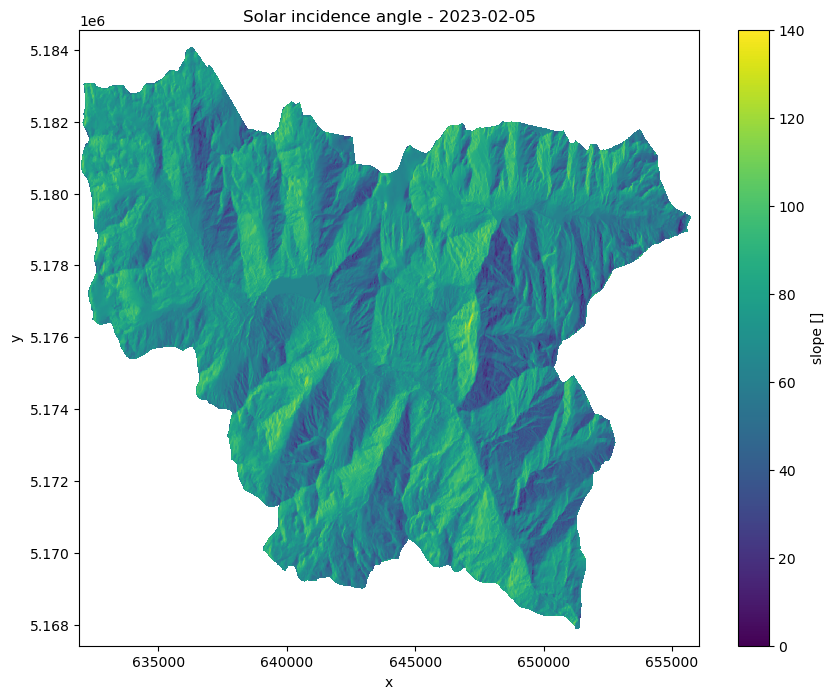

In [23]:
# save png
sia_ds = xr.open_dataset('./auxiliary_data/senales/solar_incidence_angle.nc')

plt.figure(figsize=(10, 8))
sia_ds['slope'].isel(t=1).plot(cmap='viridis', vmin=0, vmax=140)
plt.title(f"Solar incidence angle - {str(sia_ds['t'].values[1])[:10]}")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig('./auxiliary_data/senales/solar_incidence_angle.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

In [32]:
# # submit job with a name
# job = solar_incidence_angle.create_job(
#     title="solar_incidence_angle")

# job_id = job.job_id
# print(f"Job ID: {job_id}")

# job.start_and_wait()

# # download
# job.download_results(target=os.path.join(outdir))


Job ID: j-2507281053234398b67d65abbc1efa1a
0:00:00 Job 'j-2507281053234398b67d65abbc1efa1a': send 'start'
0:00:14 Job 'j-2507281053234398b67d65abbc1efa1a': created (progress 0%)
0:00:19 Job 'j-2507281053234398b67d65abbc1efa1a': created (progress 0%)
0:00:26 Job 'j-2507281053234398b67d65abbc1efa1a': created (progress 0%)
0:00:34 Job 'j-2507281053234398b67d65abbc1efa1a': created (progress 0%)
0:00:44 Job 'j-2507281053234398b67d65abbc1efa1a': running (progress N/A)
0:00:57 Job 'j-2507281053234398b67d65abbc1efa1a': running (progress N/A)
0:01:12 Job 'j-2507281053234398b67d65abbc1efa1a': running (progress N/A)
0:01:32 Job 'j-2507281053234398b67d65abbc1efa1a': running (progress N/A)
0:01:56 Job 'j-2507281053234398b67d65abbc1efa1a': running (progress N/A)
0:02:26 Job 'j-2507281053234398b67d65abbc1efa1a': running (progress N/A)
0:03:04 Job 'j-2507281053234398b67d65abbc1efa1a': running (progress N/A)
0:03:51 Job 'j-2507281053234398b67d65abbc1efa1a': running (progress N/A)
0:04:49 Job 'j-2507281

/tmp/ipykernel_236909/582837069.py:11: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(target=os.path.join(outdir))
/home/jengblom/miniconda3/envs/snowmap/lib/python3.9/site-packages/openeo/rest/job.py:192: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/home/jengblom/miniconda3/envs/snowmap/lib/python3.9/site-packages/openeo/rest/job.py:196: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


{PosixPath('auxiliary_data/senales/openEO_2023-02-02Z.tif'): {'bands': [{'name': 'slope'}],
  'eo:bands': [{'name': 'slope'}],
  'href': 'https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-2507281053234398b67d65abbc1efa1a/results/assets/ZDc2YTQ5NmItNmIyMy00ZGYxLWIxNzMtODdmNGYyNGQxYzEx/ed645c080ba334a9f8f31ec66dec359c/openEO_2023-02-02Z.tif?expires=1754305095',
  'proj:bbox': [631910, 5167410, 656060, 5184560],
  'proj:epsg': 32632,
  'proj:shape': [1715, 2415],
  'raster:bands': [{'name': 'slope',
    'statistics': {'maximum': 132.53751484642,
     'mean': 69.385087065661,
     'minimum': 6.001340095221,
     'stddev': 16.811456872991,
     'valid_percent': 53.73}}],
  'roles': ['data'],
  'title': 'openEO_2023-02-02Z.tif',
  'type': 'image/tiff; application=geotiff'},
 PosixPath('auxiliary_data/senales/openEO_2023-02-05Z.tif'): {'bands': [{'name': 'slope'}],
  'eo:bands': [{'name': 'slope'}],
  'href': 'https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-2507281053234398b67